# Q# Interop with Qiskit

The modern QDK provides interoperability with Qiskit circuits built upon the core Q# compiler infrastructure.

This core enable integration and local resource estimation without relying on external tools. Users are able to estimate resources for their Qiskit circuits locally (see the [resource estimation with Qiskit sample notebook](../../estimation/estimation-qiskit.ipynb)), leveraging the Q# compiler's capabilities for analysis, transformation, code generation, and simulation. This also enables the generation of QIR from Qiskit circuits leveraging the [modern QDKs advanced code generation capabilities](https://devblogs.microsoft.com/qsharp/integrated-hybrid-support-in-the-azure-quantum-development-kit/).

This includes support for circuits with classical instructions available in Qiskit such as for loops, if statements, switch statements, while loops, and more.

Import the Q# module.

This enables the `%%qsharp` magic and initializes a Q# interpreter singleton.

In [19]:
import qsharp

#### Qiskit circuits
We can create a simple circuit with a prepared state.

In [20]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(2, 2)
circuit.name = "state_prep"

# State vector to initialize: |ψ⟩ = (|0⟩ - |1⟩) / √2
circuit.initialize([1 / np.sqrt(2), -1 / np.sqrt(2)], 0)
circuit.h(0)
circuit.measure(0, 0)

circuit.prepare_state([1 / np.sqrt(2), -1 / np.sqrt(2)], 1)
circuit.h(1)
circuit.measure(1, 1)

We can run the circuit Q#'s backend

In [21]:
from qsharp.interop.qiskit import QSharpSimulator

backend = QSharpSimulator()
job = backend.run(circuit)
counts = job.result().get_counts()
print(counts)

{'11': 1024}


#### Parameterized Qiskit circuits
Some circuits require parameters as input. We can create a simple circuit that is parameterized.

In [22]:
from typing import List

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter


def get_theta_range(samples: int) -> List[float]:
    return np.linspace(0, 2 * np.pi, samples)


def get_parameterized_circuit(n: int) -> QuantumCircuit:
    theta = Parameter("θ")
    n = 5
    qc = QuantumCircuit(n, 1)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    qc.barrier()
    qc.rz(theta, range(n))
    qc.barrier()

    for i in reversed(range(n - 1)):
        qc.cx(i, i + 1)
    qc.h(0)
    qc.measure(0, 0)
    return qc


def get_parameterized_circuits(n: int, theta_range: List[float]) -> List[QuantumCircuit]:
    qc = get_parameterized_circuit(n)
    qc.draw()
    theta = qc.parameters[0]
    circuits = [qc.assign_parameters({theta: theta_val}) for theta_val in theta_range]
    return circuits

Attempting to run without binding all input will generate an error in the job.

In [23]:
from qsharp import QSharpError
from qsharp.interop.qiskit import QSharpSimulator
from qiskit.providers import JobStatus

circuit = get_parameterized_circuit(3)
backend = QSharpSimulator()
try:
    backend.qir(circuit)
except QSharpError as e:
    print(e)

params are required when the circuit has unbound input parameters
  help: Parameters: θ: Double


Any parameters must be bound before we can run the circuit. This is done by setting the `params` argument to the `run` function.

In [24]:
from qsharp.interop.qiskit import QSharpSimulator
from qiskit.providers import JobStatus

circuit = get_parameterized_circuit(3)
backend = QSharpSimulator()
# todo: should we support params={"θ": "0.5"}?
job = backend.run(circuit, params="0.5")
result = job.result()
assert job.status() == JobStatus.DONE
counts = result.get_counts()
print(counts)

{'1': 922, '0': 102}


#### Asychronous jobs

In [25]:
from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor(max_workers=4)

Run the circuits

In [26]:
num_samples = 256
theta_range = get_theta_range(num_samples)
circuits = get_parameterized_circuits(5, theta_range)

backend = QSharpSimulator()
job = backend.run(circuits, executor=executor)
job.wait_for_final_state(wait=0.5)
result = job.result()
print(job.status())
counts = job.result().get_counts()

JobStatus.DONE


Render the results using numpy

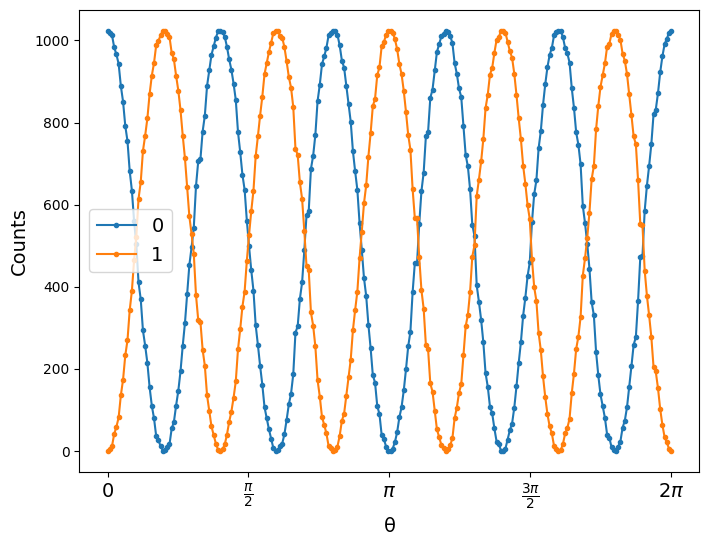

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

theta_range = get_theta_range(num_samples)
ax.plot(theta_range, list(map(lambda c: c.get("0", 0), counts)), ".-", label="0")
ax.plot(theta_range, list(map(lambda c: c.get("1", 0), counts)), ".-", label="1")

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(
    ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=14
)
ax.set_xlabel("θ", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.legend(fontsize=14)

## Classical instructions in circuits

### Run Qiskit with classical instructions


In [29]:
from qiskit.circuit import (
    Clbit,
    QuantumCircuit,
    Qubit,
)

from qsharp import QSharpError, TargetProfile

qubit = Qubit()
clbit = Clbit()
case1 = QuantumCircuit([qubit, clbit])
case1.x(0)
case2 = QuantumCircuit([qubit, clbit])
case2.z(0)
qc = QuantumCircuit([qubit, clbit])
qc.switch(clbit, [(True, case1), (False, case2)], [0], [0])

backend = QSharpSimulator()
try:
    print(backend.qasm3(qc))
except QSharpError as e:
    print(e)
print("Generating QIR again with profile override")
print(backend.qir(qc, target_profile=TargetProfile.Adaptive_RI))

OPENQASM 3.0;
include "stdgates.inc";
bit _bit0;
int switch_dummy;
qubit _qubit0;
switch_dummy = _bit0;
switch (switch_dummy) {
  case 1 {
    x _qubit0;
  }
  case 0 {
    z _qubit0;
  }
}

Generating QIR again with profile override


QSharpError: [31mQsc.TypeCk.TyMismatch[0m

  [31m×[0m type error
[31m  ╰─▶ [0mexpected Int, found BigInt
   ╭─[[36;1;4m<entry>[0m:1:1]
 [2m1[0m │ OPENQASM 3.0;
   · [35;1m▲[0m
 [2m2[0m │ include "stdgates.inc";
   ╰────
[31mQsc.TypeCk.TyMismatch[0m

  [31m×[0m type error
[31m  ╰─▶ [0mexpected BigInt, found Int
    ╭─[[36;1;4m<entry>[0m:3:1]
 [2m 3[0m │     bit _bit0;
 [2m 4[0m │ [35;1m╭[0m[35;1m─[0m[35;1m▶[0m int switch_dummy;
 [2m 5[0m │ [35;1m│[0m   qubit _qubit0;
 [2m 6[0m │ [35;1m│[0m   switch_dummy = _bit0;
 [2m 7[0m │ [35;1m│[0m   switch (switch_dummy) {
 [2m 8[0m │ [35;1m│[0m     case 1 {
 [2m 9[0m │ [35;1m╰[0m[35;1m─[0m[35;1m▶[0m     x _qubit0;
 [2m10[0m │       }
    ╰────


### Run Qiskit circuit in new interpreter
The `run_qiskit` function can execute a qiskit circuit as a program using the output semantics of OpenQASM 3.0 (the circuit is converted to qasm3 before execution).

In [ ]:
from qiskit import QuantumCircuit

def ghz():
    circuit = QuantumCircuit(4, 3)
    circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.measure([2, 1, 0], [1, 0, 2])
    return circuit


circuit = ghz()
print(circuit.draw(output="text"))
print(QSharpSimulator().run(circuit).result().get_counts())

### Run Qiskit circuit in interactive session

In [ ]:
from qsharp.interop import eval_qiskit
from qiskit import QuantumCircuit

def ghz():
    circuit = QuantumCircuit(4, 3)
    circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.measure([2, 1, 0], [1, 0, 2])
    return circuit

circuit = ghz()
print(eval_qiskit(circuit))

In [ ]:
from qsharp import dump_machine
from qsharp import print_locals

print_locals()
dump_machine()

In [ ]:
%%qsharp
Message($"Hello from Q# {c}");
c

### Importing Qiskit circuits as operations

We can convert qiskit circuits into the equivalent entry point operation definitions. Using the `import_qiskit` call we get back the name of the callable created which is now available in the active session.

In the future, using the `import_qiskit` call would either promote qubit decls into parameters or be forced to clean them up before returning (ensuring any qubits allocated are in the Zero state and released).

In [ ]:
from qsharp.interop import import_qiskit
from qsharp import init
from qiskit import QuantumCircuit
init()

def ghz():
    circuit = QuantumCircuit(4, 3)
    circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.measure([2, 1, 0], [1, 0, 2])
    return circuit

circuit = ghz()
print(import_qiskit(circuit, "ghz_name_override"))

In [ ]:
%%qsharp
ghz_name_override()

// We can also pass the callable to a function and run it there
operation RunQiskitCircuit(callable : (() => Result[])) : Result[] {
    Message("about to run the callable");
    let res = callable();
    Message("callable ran");
    res
}

// pass the qiskit callable to the function
RunQiskitCircuit(ghz_name_override)

A hidden detail of the qiskit implementation is the creation of a `QSharpVirtualBackend` which allows us to do the circuit transpilation with classical logic and the intrinsic gate set defined in Q#.

In [ ]:
from qsharp.interop._qiskit import QSharpVirtualBackend
from qsharp import init
init()

def ghz():
    circuit = QuantumCircuit(4, 3)
    circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.measure([2, 1, 0], [1, 0, 2])
    return circuit


circuit = ghz()
backend = QSharpVirtualBackend()
print(backend.run(circuit))

from qsharp import dump_machine
from qsharp import print_locals

print_locals()
dump_machine()

Taking the above sample with input lifting with `import_qiskit` would create the equivalent to this Q# code:

In [ ]:
%%qsharp

operation ghz(q: Qubit[]) : Result[] {
    H(q[0]);
    CNOT(q[0], q[1]);
    CNOT(q[1], q[2]);
    [M(q[1]), M(q[2]), M(q[0])]
}

## Errors
### Parse errors
Parse are exceptions. 

We can catch and handle parse errors prior to compilation.

In [ ]:
from qsharp.interop import QasmError

try:

except QasmError as ex:
    print(ex)

### Runtime Errors
We can also catch and handle runtime errors, mapping the error back to the original code.

Here we'll run an example which tries to access the fifth element in an array with only two elements.

In [ ]:
from qsharp import QSharpError
from qsharp.interop import QasmError


try:
    circuit = QuantumCircuit(2)
    circuit.x(0)
    backend = QSharpSimulator()
    print(backend.run(circuit).result())
except QasmError as ex:
    print(ex)


The next example is for `QIR` code generation. When generating `QIR`, all output registers must be read into before generating QIR. Failure to do so results in a `QSharpError`

In [ ]:
circuit = QuantumCircuit(2, 2)
circuit.x(0)
circuit.measure(0, 1)
backend = QSharpSimulator()
try:
    # TODO: the error message is incorrect:
    # Unsupported target profile. Initialize Q# by running `qsharp.init(target_profile=qsharp.TargetProfile.Base)` before performing code generation.
    print(backend.qir(circuit))
except QSharpError as ex:
    print(ex)

print("Trying again with adaptive profile")
print(backend.qir(circuit, target_profile=TargetProfile.Adaptive_RI))

A runtime error that's not caught gets reported as a Python exception.

#### Unsupported language features, `QasmError`, and `QSharpError`
The modern QDK's interop with Qiskit is based on Qiskit's OpenQASM 3 support. Qiskit supports a subset of OpenQASM 3 features which may cause issues during conversion. If the Qiskit OpenQasm `Exporter` or OpenQasm parser don't support the feauture yet, a `QasmError` is raised prior to conversion. If there is a QASM parsing failure, this is likely an issue with the Qiskit libraries parsing or export functionality.

Any failure to transform the OpenQASM into Q#'s internal representation will throw a `QSharpError` to distinguish the scenarios.